# Machine Learning Engineer Nanodegree

## Capstone Project

Daniel Bank
November 3rd, 2018

# Overview

## Photometric LSST Astronomical Time Series Classification Challenge

The Large Synoptic Survey Telescope (LSST), currently under construction in the Atacama desert of Chile, is the most awesome telescope that mankind will have built thus far in history.  It features an 8.4m mirror, 3.2 gigapixel camera, and 6.5m effective aperture [[1](#references)].  Every night, it will gather between 20 and 40 TB of image data of the southern sky.  While sifting through that much data to identify cosmological objects would be impractical for humans, it is a perfect use case for machine learning.

In preparation for the massive amounts of observations that will come from the LSST, an open data competition has been launched on [Kaggle](https://www.kaggle.com) called the Photometric LSST Astronomical Time Series Classification Challenge ([PLAsTiCC](https://www.kaggle.com/c/PLAsTiCC-2018)).  The goal of the challenge is to correctly classify time-varying cosmological objects in simulated astronomical time-series data similar to the data that the LSST will generate.

I first became aware of this challenge while browsing the Kaggle competitions.  My personal interest in astronomy stems partly from my background as a Physics major but more so from son, Arthur, who loves everything about the night sky.  He has taught me to really appreciate the beauty of the cosmos.

## Problem Statement

A

## Metrics

B

# Analysis

In [10]:
# Import Libraries and Configure Notebook

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import chain
sns.set_style('whitegrid')
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)
import cesium.featurize as featurize
from gatspy.periodic import LombScargleMultiband, LombScargleMultibandFast
import pdb

In [11]:
# Load Training Data

train_series = pd.read_csv('../input/training_set.csv')
train_metadata = pd.read_csv('../input/training_set_metadata.csv')
test_metadata = pd.read_csv('../input/test_set_metadata.csv')

## Data Exploration

One interesting observation is that classes in the training data set divide evenly into intragalactic and extragalactic categories.  There are no classes that are present in both categories.  Class 99 (the unknown classification) is not present at all in the training dataset.  This last point raises an interesting challenge for our model:  How to predict this mystery class when it is not present at all in the training data?  We will investigate possible solutions to this in the following **Algorithms and Techniques** section.

Another challenge is that the training dataset is a small subset of the test dataset and is also a poor representation of it.  This design decision was made to imitate the real-world challenges that astronomers face when trying to classify cosmological objects.

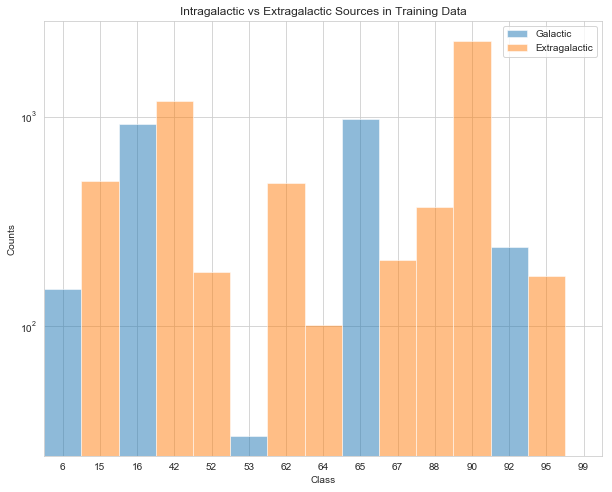

In [19]:
# Galactic vs Extragalactic Code by Kyle Boone
# https://www.kaggle.com/kyleboone/naive-benchmark-galactic-vs-extragalactic

targets = np.hstack([np.unique(train_metadata['target']), [99]])
target_map = {j:i for i, j in enumerate(targets)}
target_ids = [target_map[i] for i in train_metadata['target']]
train_metadata['target_id'] = target_ids

# Intragalactic sources have no redshift! (hostgal_spez == 0)
intragalactic_cut = train_metadata['hostgal_specz'] == 0
plt.figure(figsize=(10, 8))
plt.hist(train_metadata[intragalactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Galactic')
plt.hist(train_metadata[~intragalactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Extragalactic')
plt.xticks(np.arange(15)+0.5, targets)
plt.gca().set_yscale("log")
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim(0, 15)
plt.title('Intragalactic vs Extragalactic Sources in Training Data')
plt.legend();

## Exploratory Visualization

It is helpful to look at the example passband data for the various classes to get an understanding of what the data looks like and understand some of the distinguishing features between classes.  As there are 14 classes represented in the training dataset, we will only examine two of the more interesting classes: Class 92 and Class 42.  Class 92 are highly periodic while Class 42 exhibit what appear to be "burst" events with diminishing activity after that.  The author of this code, [Mithrillion](https://www.kaggle.com/mithrillion), theorizes that Class 92 are regular variable stars and Class 42 are supernovae events.

In [3]:
# Visualization Code by Mithrillion
# https://www.kaggle.com/mithrillion/all-classes-light-curve-characteristics-updated

groups = train_series.groupby(['object_id', 'passband'])
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: block['flux'].values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: block['flux_err'].values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()

def fit_multiband_freq(tup):
    idx, group = tup
    t, f, e, b = group['mjd'], group['flux'], group['flux_err'], group['passband']
    model = LombScargleMultiband(fit_period=True)
    model.optimizer.period_range = (0.1, int((group['mjd'].max() - group['mjd'].min()) / 2))
    model.fit(t, f, e, b)
    return model

def get_freq_features(N, subsetting_pos=None):
    if subsetting_pos is None:
        subset_times_list = times_list
        subset_flux_list = flux_list
    else:
        subset_times_list = [v for i, v in enumerate(times_list) 
                             if i in set(subsetting_pos)]
        subset_flux_list = [v for i, v in enumerate(flux_list) 
                            if i in set(subsetting_pos)]
    feats = featurize.featurize_time_series(times=subset_times_list[:N],
                                            values=subset_flux_list[:N],
                                            features_to_use=['skew',
                                                            'percent_beyond_1_std',
                                                            'percent_difference_flux_percentile'
                                                            ],
                                            scheduler=None)
    subset = train_series[train_series['object_id'].isin(
        train_metadata['object_id'].iloc[subsetting_pos].iloc[:N])]
    models = list(map(fit_multiband_freq, subset.groupby('object_id')))
    feats['object_pos'] = subsetting_pos[:N]
    feats['freq1_freq'] = [model.best_period for model in models]
    return feats, models

unique_classes = train_metadata['target'].unique()

def get_class_feats(label, N=10):
    class_pos = train_metadata[train_metadata['target'] == label].index
    class_feats, class_models = get_freq_features(N, class_pos)
    return class_feats, class_models

def plot_phase_curves(feats, models, use_median_freq=False, hide_undetected=True, N=10):
    for i in range(N):
        freq = feats.loc[i, 'freq1_freq'].median()
        freq_min = feats.loc[i, 'freq1_freq'].min()
        freq_std = feats.loc[i, 'freq1_freq'].std()
        skew = feats.loc[i, 'skew'].mean()
        object_pos = int(feats.loc[i, 'object_pos'][0])
        f, ax = plt.subplots(1, 2, figsize=(14, 4))
        sample = train_series[train_series['object_id'] ==
                              train_metadata['object_id'].iloc[object_pos]].copy()
        colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
        score = models[i].score(models[i].best_period)
        
        ax[0].scatter(x=sample['mjd'], 
                   y=sample['flux'], 
                   c=[colors[b] for b in sample['passband']],
                   s=8, alpha=0.8)
        ax[0].vlines(sample['mjd'], 
                  sample['flux'] - sample['flux_err'],
                  sample['flux'] + sample['flux_err'],
                  colors=[colors[b] for b in sample['passband']],
                  linewidth=1, alpha=0.8)
        
        sample['phase'] = (sample['mjd'] / models[i].best_period) % 1
        ax[1].scatter(x=sample['phase'], 
                   y=sample['flux'], 
                   c=[colors[b] for b in sample['passband']],
                   s=8, alpha=0.8)
        ax[1].vlines(sample['phase'], 
                  sample['flux'] - sample['flux_err'],
                  sample['flux'] + sample['flux_err'],
                  colors=[colors[b] for b in sample['passband']],
                  linewidth=1, alpha=0.8)
        x_range = np.linspace(sample['mjd'].min(), sample['mjd'].max(), 1000)
        for band in range(6):
            y = models[i].predict(x_range, band)
            xs = (x_range / models[i].best_period) % 1
            ords = np.argsort(xs)
            ax[1].plot(xs[ords], y[ords], c=colors[band], alpha=0.4)
        
        title = ax[0].get_title()
        ax[0].set_title('time')
        ax[1].set_title('phase')
        f.suptitle(title + f'object: {sample["object_id"].iloc[0]}, '
                   f'class: {train_metadata["target"].iloc[object_pos]}\n'
                   f'period: {models[i].best_period: .4}, '
                   f'period score: {score: .4}, '
                   f'mean skew: {skew:.4}', y=1.1)
        plt.show()

In [4]:
%%capture capt
feats, models = get_class_feats(92)

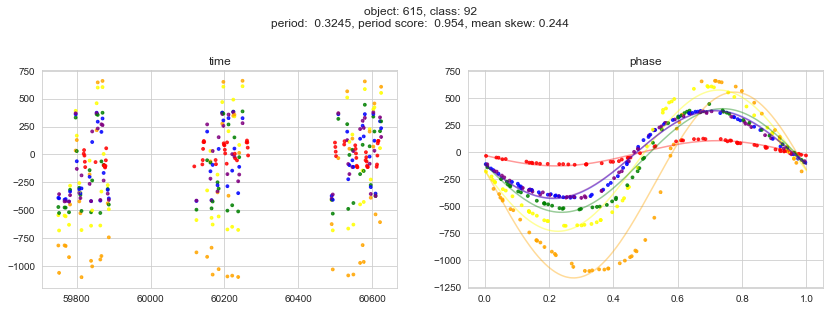

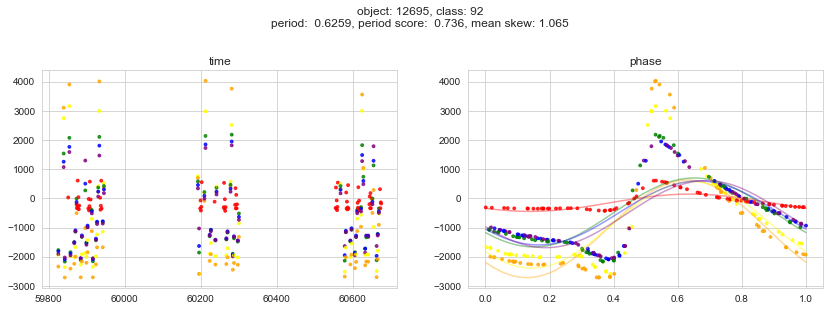

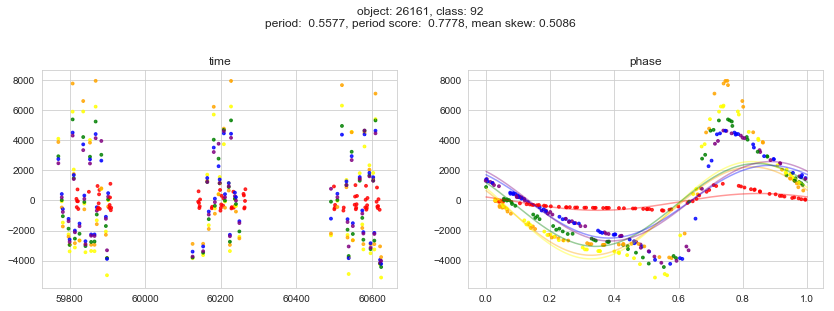

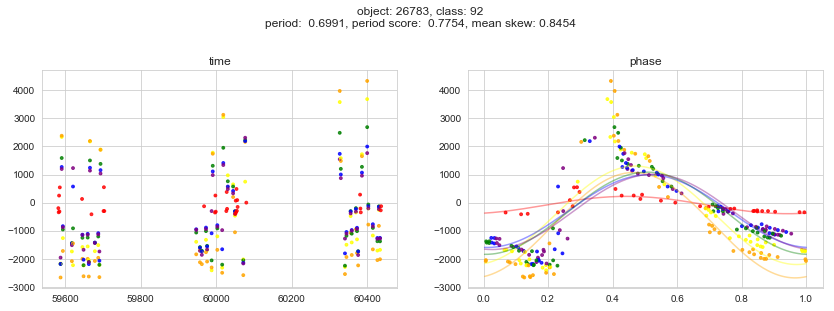

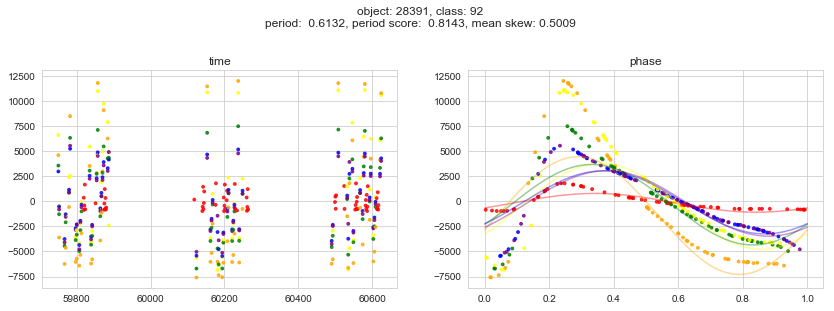

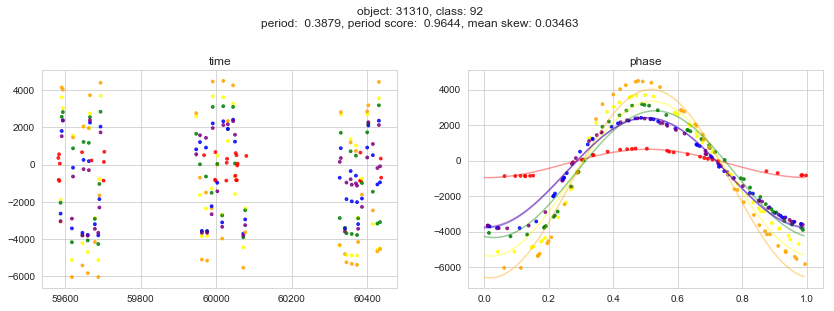

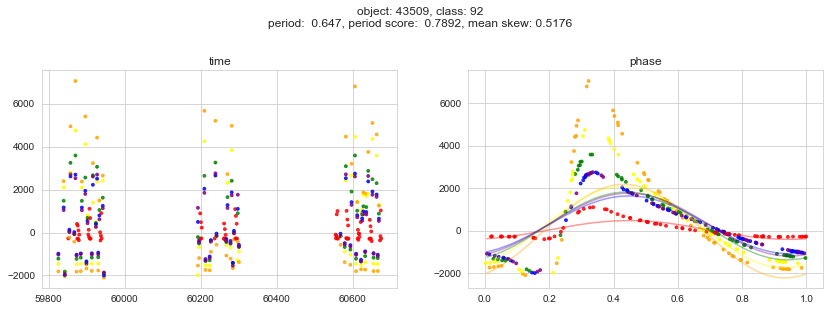

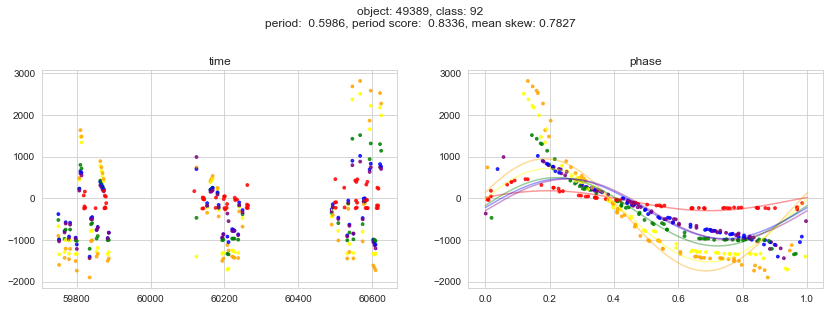

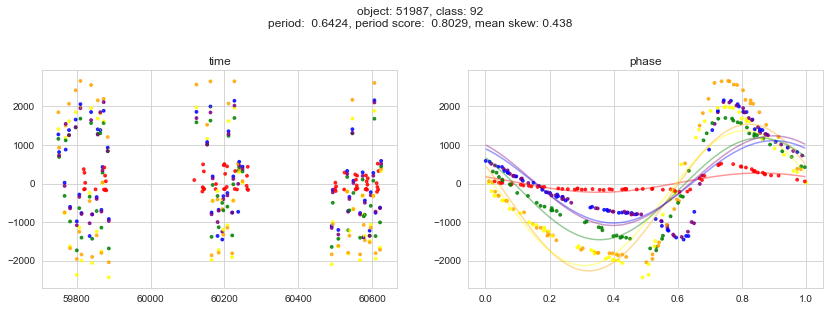

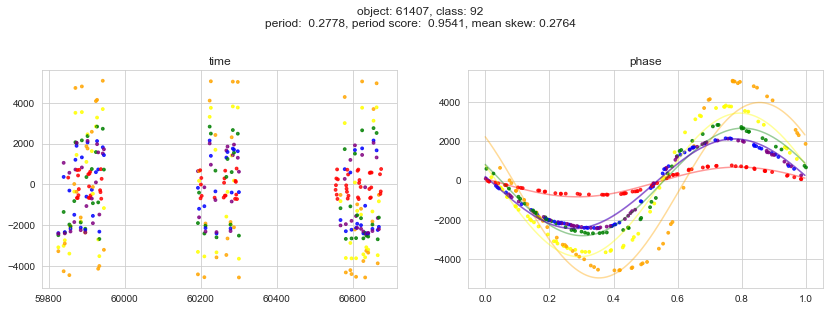

In [6]:
plot_phase_curves(feats, models)

In [7]:
%%capture capt
feats, models = get_class_feats(42)

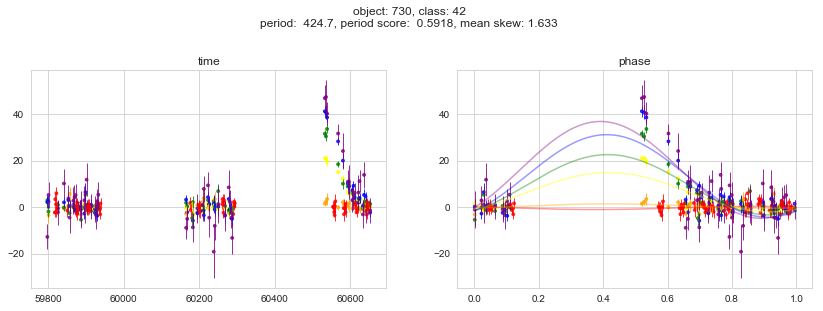

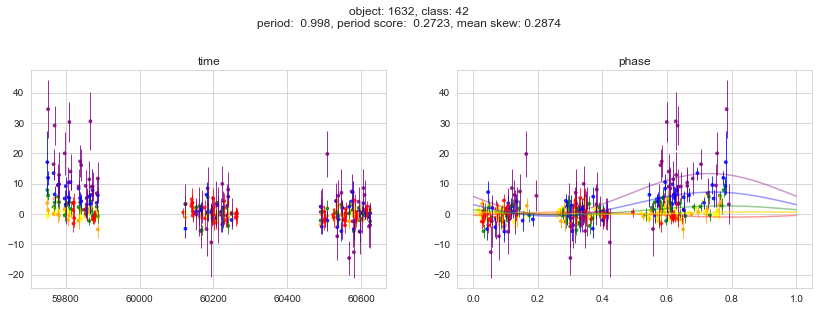

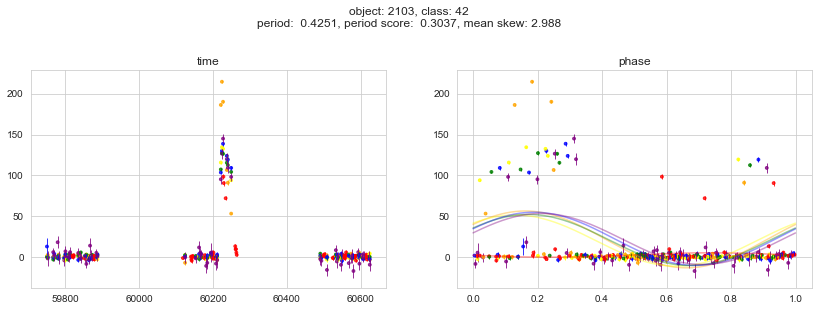

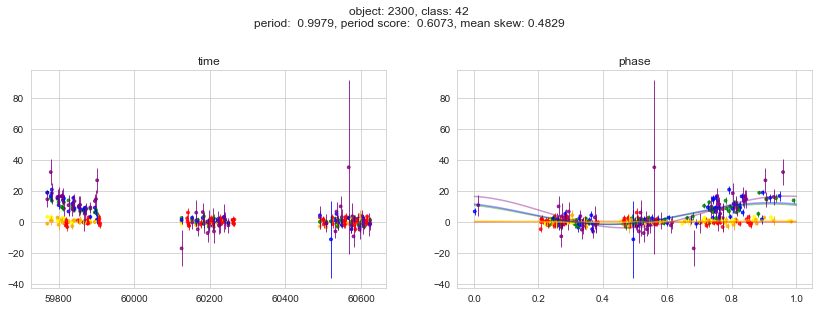

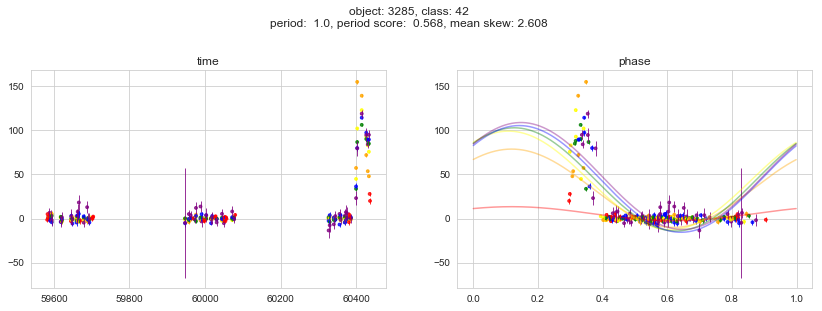

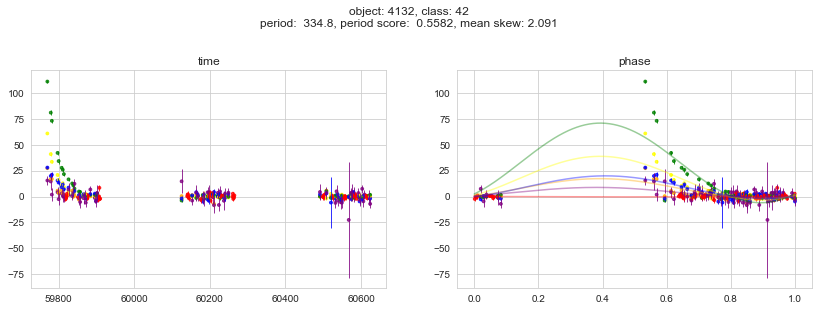

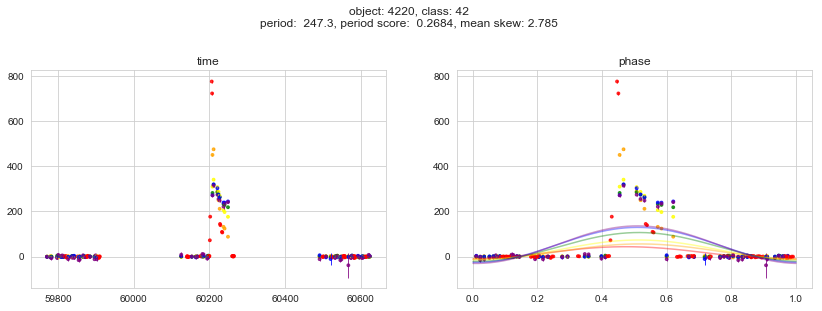

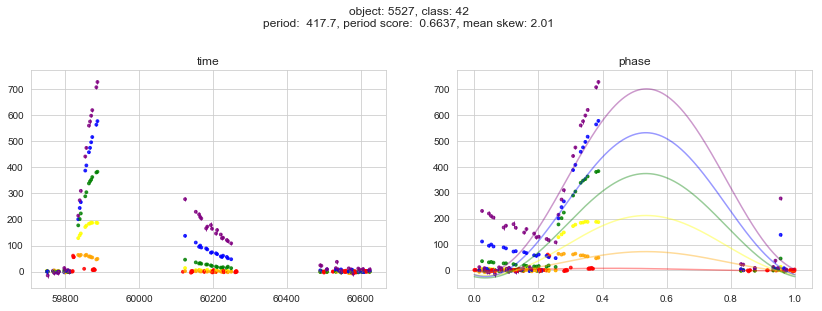

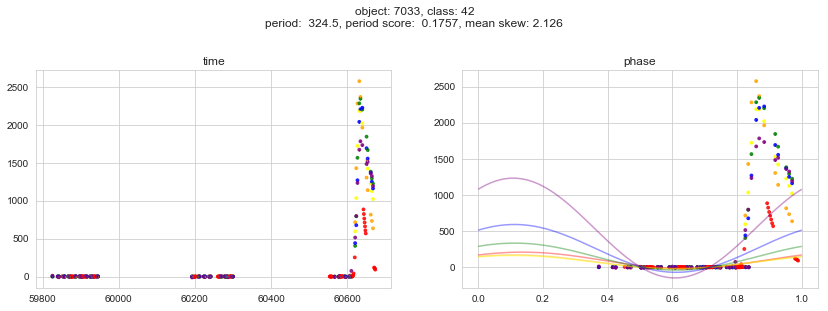

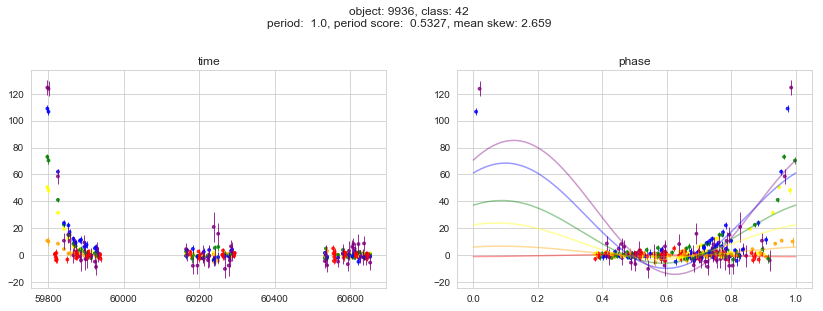

In [8]:
plot_phase_curves(feats, models)

## Algorithms and Techniques

- Partition data along intra- extra-galactic
- How to handle class 99?  DBScan?  Something else?
- Learning model (CNN...)
- PCA?

## Benchmark
The PLAsTiCC team has provided a [naive classifier](https://www.kaggle.com/michaelapers/the-plasticc-astronomy-classification-demo) for the challenge.  The naive classifier is designed as follows:

1. The raw tabular data is converted into a form suitable for analysis.  Using the `cesium` package for Python, `Timeseries` objects are constructed for each light curve.
2. The data is split into a training and test set.
3. The dimensionality of the training data is reduced using Principle Component Analysis (PCA).  The result of this step are features which are linear combinations of the `passband` data.  With just eight (8) features, we can account for almost all of the explained variance.
4. The reduced dataset is fit with a `RandomForestClassifier`.

### Evaluation Metrics

The performance of the naive classifier on the test data can be visualized in the following confusion matrix:

![Naive Classifier Confusion Matrix](https://github.com/danielbank/PLAsTiCC/blob/master/.github/naive_classifier_confusion_matrix.png?raw=true)

In this matrix, we can see the model's predicted labels versus the true labels for the test set.  Ideally, this confusion matrix would be the Identity matrix, with all values along the diagonal being 1 and everything else being 0.  That would mean that the model predicted the correct label 100% of the time.

When designing my classifier, I will generate a similar confusion matrix so that my results can be objectively compared to the naive classifier.  My objective is to have an average prediction accuracy per label that is higher than the naive classifier's accuracy of 0.518 (see calculation below):

```
(1.00 + 0.06 + 0.31 + 0.23 + 0.02 +
 0.19 + 0.86 + 0.76 + 0.34 + 0.59 +
 0.96 + 0.70 + 0.36 + 0.87) / 14
= 0.518
```

# PLAsTiCC Prediction Pipeline

## Data Preprocessing

The data for this challenge has been provided in a curated form by the PLAsTiCC Team.  As such most data preprocessing techniques, like defaulting missing data or one-hot encoding text categories, are not required for our pipeline.  We do use `sklearn.preprocessing.StandardScaler` to scale features to unit variance.

## Feature Engineering

### Partitioning Intragalactic and Extragalactic Sources

As we saw in the Data Exploration section, we can narrow number of possible classifications of the training data to 5 out of 14 possibilities for galactic sources and 10 out of 14 possibilities for extragalactic sources.  It makes sense to partition our data along these lines.

In [ ]:
# Partition the Training Data (Intragalactic vs Extragalactic)

# From an earlier step:
# intragalactic_cut = train_metadata['hostgal_specz'] == 0



## Principle Component Analysis

## Convolutional Neural Network

# Results

## Model Evaluation and Validation

## Justification

# Conclusion

## Free-Form Visualization

## Reflection

## Improvement

<a id='references'></a>

# References

<a name="reference-1"></a>[1] - [PLAsTiCC Astronomy Starter Kit](https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit)